<a href="https://colab.research.google.com/github/alfiinyang/Text2Excel/blob/main/text2excel_1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Excel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Extract Data from the Existing Spreadsheet
Load the data from the existing spreadsheet into a DataFrame.

In [ ]:
!pip install openpyxl
!pip install transformers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd

# Load existing Excel file
# file_path = r'C:\Users\ISLP11\Downloads\cash_flow.xlsx'
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_CAH.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')
df2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_access.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')

# Ensure the DataFrame contains the required columns
df = df[['COMMENT', 'CATEGORY']]
df2 = df2[['COMMENT', 'CATEGORY']]

print(df.head(), df2.head())

<ipython-input-66-357ec6ce81ec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_CAH.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')


                   COMMENT  CATEGORY
0             POS cash out  CASH OUT
1       Lunch: Ogbono soup      FOOD
2                     Fufu      FOOD
3  Insecticide: knock down   UTILITY
4               Cleaner TP    GIVING                    COMMENT  CATEGORY
0  Second account transfer  CASH OUT
1          Transfer charge   CHARGES
2     Card maintenance fee   CHARGES
3          Etenwan lending      LOAN
4                  Haircut   UTILITY


<ipython-input-66-357ec6ce81ec>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_access.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')


In [ ]:
df.isna().sum(), df2.isna().sum()

(COMMENT     38
 CATEGORY    38
 dtype: int64,
 COMMENT     44
 CATEGORY    44
 dtype: int64)

In [ ]:
df.dropna(inplace=True), df2.dropna(inplace=True)

<ipython-input-68-8a915bc3fa87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True), df2.dropna(inplace=True)


(None, None)

In [ ]:
dfT=pd.concat([df, df2])
dfT.shape, df.shape, df2.shape
dfT.head()

,COMMENT,CATEGORY
0,POS cash out,CASH OUT
1,Lunch: Ogbono soup,FOOD
2,Fufu,FOOD
3,Insecticide: knock down,UTILITY
4,Cleaner TP,GIVING


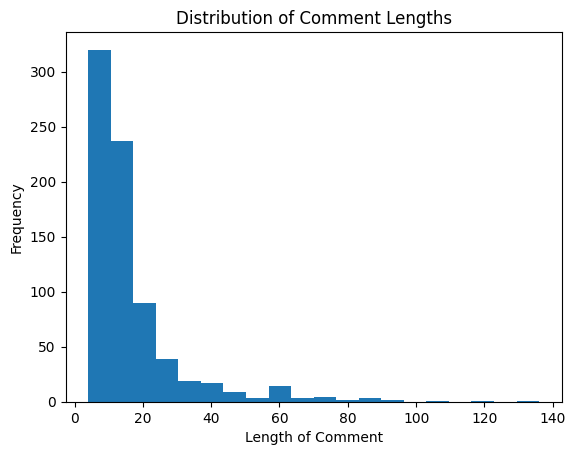

In [ ]:
max_l = lambda x: max([len(x) for x in x])
maxin = max_l(dfT['COMMENT'])
mal_i = lambda x: [len(x) for x in x]
spread = mal_i(dfT['COMMENT'])

import matplotlib.pyplot as plt
plt.hist(spread, bins = 20)
plt.xlabel('Length of Comment')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths')
plt.show()

In [ ]:
import numpy as np

# Calculate the 95th percentile
max_length = int(np.percentile(spread, 95))
print(f"95th percentile of comment lengths: {max_length}")


95th percentile of comment lengths: 45


## 2. Preprocess the Data
Prepare the data for training by splitting it into training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(dfT, test_size=0.2, random_state=42)

# Reset the index of the DataFrames
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

## 3.1 Train a Text Classification Model
Fine-tune a pre-trained model like BERT using Hugging Face's transformers library.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['COMMENT'].tolist()
        self.labels = dataframe['CATEGORY'].astype('category').cat.codes.tolist() # convert categories to int codes
        self.max_len = max_len
        self.label_map = {i: c for i, c in enumerate(dataframe['CATEGORY'].astype('category').cat.categories)}  # map categories to int codes

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 45 #128

# Create the custom datasets
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer, max_len)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['CATEGORY'].unique()))

# Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/text2excel/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/text2excel/logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=1,
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True
)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss


## 3.2 Train a Text Classification Model with Sliding Window Approach for Handling Longer Sequences
Fine-tune a pre-trained model like BERT using Hugging Face's transformers library.

In [ ]:
### code supporting text chunk processing

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import Dataset

# Define a custom dataset class
class CustomDataset2(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, stride):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['COMMENT'].tolist()
        self.labels = dataframe['CATEGORY'].astype('category').cat.codes.tolist()
        self.max_len = max_len
        self.stride = stride # chunk slider
        self.label_map = {i: c for i, c in enumerate(dataframe['CATEGORY'].astype('category').cat.categories)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize and split the text into chunks using the sliding window approach
        tokens = self.tokenizer.tokenize(text)
        chunks = []
        for i in range(0, len(tokens), self.stride):
            chunk = tokens[i:i + self.max_len]
            if len(chunk) == 0:
                break
            chunk = self.tokenizer.convert_tokens_to_ids(chunk)
            chunk = self.tokenizer.build_inputs_with_special_tokens(chunk)
            if len(chunk) > self.max_len:
                chunk = chunk[:self.max_len-1] + [self.tokenizer.sep_token_id]
            chunks.append(chunk)

        # Create a tensor for each chunk
        encodings = []
        attention_masks = []
        for chunk in chunks:
            encoding = torch.tensor(chunk, dtype=torch.long)
            attention_mask = torch.ones(len(chunk), dtype=torch.long)
            padding_length = self.max_len - len(chunk)
            if padding_length > 0:
                encoding = torch.cat((encoding, torch.zeros(padding_length, dtype=torch.long)))
                attention_mask = torch.cat((attention_mask, torch.zeros(padding_length, dtype=torch.long)))
            encodings.append(encoding)
            attention_masks.append(attention_mask)

        # Combine all chunk encodings and attention masks into a single tensor
        encodings = torch.stack(encodings)
        attention_masks = torch.stack(attention_masks)

        return {
            'text': text,
            'input_ids': encodings,
            'attention_mask': attention_masks,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 45
stride = 30

# Create the custom datasets
train_dataset_2 = CustomDataset2(train_df, tokenizer, max_len, stride)
val_dataset_2 = CustomDataset2(val_df, tokenizer, max_len, stride)

In [ ]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['CATEGORY'].unique()))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=1,
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True
)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: too many values to unpack (expected 2)

## 4. Save the Trained Model and Label Map
Save the model and the label map for future use.

In [ ]:
iterr_ = 0
mod = '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model'

In [ ]:
iterr_ += 0.1
mod = mod + str(iterr_)

In [ ]:
model.save_pretrained(mod)
tokenizer.save_pretrained(mod)

('/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/added_tokens.json')

In [ ]:
import json

# Save the label map to a JSON file
with open('/'.join([mod, 'label_map.json']), 'w') as file:
    json.dump(train_dataset.label_map, file)

## 5. Integrate the Trained Model
Use the trained model to classify new descriptions.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import json

iterr_ = 0
mod = '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model'
iterr_ += 0.1
mod = mod + str(iterr_)

# Load the label map from the JSON file
with open('/'.join([mod,'label_map.json']), 'r') as file:
    label_map = json.load(file)

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(mod)
tokenizer = BertTokenizer.from_pretrained(mod)
max_len = 45

# Define a function to classify a new description
def classify_description(description):
    with torch.no_grad():
        encoding = tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)
        return label_map[str(prediction.item())]

In [ ]:
# Example usage
new_description = "Meat, ikpa, stockfish, dry fish, afang, crayfish, waterleaf, black bag, grinding, onions, pepper, banana, plantain"
category = classify_description(new_description)
print(f'The category for "{new_description}" is {category}.')

The category for "Meat, ikpa, stockfish, dry fish, afang, crayfish, waterleaf, black bag, grinding, onions, pepper, banana, plantain" is FOOD.


### Text2Excel

In [ ]:
import pandas as pd
import re

def txt2xl(input_text):
    # Regular expression patterns
    date_pattern = r'\d{2}/\d{2}/\d{4}'
    entry_pattern1 = r'([\w\s,()]+)'
    entry_pattern2 = r'([\w\s,()]+) - ([\d, ]+)'

    t_entries = input_text.split('\n\n')
    data = []


    # Extract entries by date
    for line in t_entries:
      # Extract date
      date = re.search(date_pattern, line).group()

      # Extract entries
      entries = line[len(date)+1:].strip().split('\n')

      for i, entry in enumerate(entries):
          if re.findall(entry_pattern2, entry) == []:
              desc = re.findall(entry_pattern1, entry)[0]
              if desc.lower().strip().endswith('cash out'):
                  desc = 'POS cash out'
                  cost = re.findall(r'\d+', entry)[0] + '000'
              else:
                  cost = '0'
              entries[i] = date, desc, cost#, classify_description(desc)
          else:
              desc, cost = re.findall(entry_pattern2, entry)[0]
              entries[i] = date, desc, cost#, classify_description(desc)

      # Store entries in a DataFrame
      for date, item, cost in entries:
          total_cost = '=SUM(' + cost + ')'
          if item == 'POS cash out':
              data.append([date, item, total_cost, '', '', ''])
          else:
              data.append([date, item, '', total_cost, '', ''])

    new_df = pd.DataFrame(data, columns=['DATE', 'COMMENT', 'CREDIT', 'DEBIT', 'SOURCE', 'CATEGORY'])
    new_df['DATE'] = pd.to_datetime(new_df.DATE, dayfirst=True)
    new_df['DATE'] = new_df.DATE.dt.date
    new_df['CATEGORY'] = new_df.COMMENT.map(classify_description)

    return new_df

In [ ]:
mmm = """30/06/2024
10k cash out
Water (2), pap (2), egg (6), coke - 700, 200, 1200, 300

01/07/2024
Bread, fufu (3), tigernut - 900, 300, 200
Office TP - 700
TP home - 100

02/07/2024
ORS, flagyl - 250, 500
Office TP - 450
TP home - 100

03/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

04/07/2024
Office TP - 600
Tigernut - 200
Chinonso - 100
TP home - 100

05/07/2024
Office TP - 450
TP home - 100
Orange (3) - 200

06/07/2024
Bread, pap (3) - 850, 300
10k cash out

08/07/2024
Office TP - 600
TP home - 100

09/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

10/07/2024
Fufu (3) - 300
Office TP - 600
Passenger assist - 100
TP home - 100
Bread, milk (2) - 850, 1000

11/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

12/07/2024
Fufu (4) - 400
Office TP - 700
TP home - 600

13/07/2024
Ecogas TP - 400

15/07/2024
Office TP - 600
TP home - 200
Passenger TP - 100

16/07/2024
10k cash out
Office TP - 600
Fufu (4) - 400
TP home - 100

17/07/2024
Office TP - 600
Lunch (tigernut, small chops (2), yam/potato and sauce) - 2000
TP home - 100
Bread, banana - 800, 400

18/07/2024
Office TP - 600
TP home - 600
Meat, ikpa, stockfish, dry fish, afang, crayfish, waterleaf, black bag, grinding, onions, pepper, banana, plantain - 2000, 1000, 2300, 500, 600, 100, 400, 100, 100, 1500, 1000, 1500, 2000

19/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

20/07/2024
10k cash out

21/07/2024
Disandat TP - 100
Water, Star beer - 300, 800
TP home - 200

22/07/2024
Fufu (5), malt (2) - 500, 1200
Trash disposal - 200
Chidera TP - 500

23/07/2024
Office TP - 600
TP home - 100
Fufu (9) - 900

24/07/2024
Office TP - 600
TP home - 100
Neighbour TP - 100
Bread, groundnut - 850, 2500

25/07/2024
Office TP - 700
TP home - 100

26/07/2024
10k cash out
Tomatoes, pepper, bell pepper, ginger, meat, grinding, water (2 + 4 sachets) - 3000, 1000, 1000, 100, 2000, 200, 800
TP home - 200

27/07/2024
Haircut - 500

29/07/2024
10k cash out
Fufu (3) - 300
Office TP - 700
Shortbread (200 change left) - 2200
TP home - 200
Bread, chi exotic - 950, 600

30/07/2024
Office TP - 700
TP home - 100
Ecogas TP - 500

31/07/2024
Bread - 950
Office TP - 800
TP home - 100
Stock fish, dried fish, meat, crayfish, ikpa, okra, ugwu, pepper, grinding - 400, 600, 2000, 600, 1000, 600, 100, 500, 100
Condom (3) - 2100
Vitamin c - 200
Chidera TP - 1000

01/08/2024
Office TP - 700
TP home - 200
Bread - 950

05/08/2024
10k cash out
Milk, pap (4), smoove (2) - 800, 400, 500

06/08/2024
Bread, Maltina - 950, 600

07/08/2024
Cardbury - 300
Office TP - 750"""

In [ ]:
cat_df = txt2xl(mmm)
cat_df.head()

,DATE,COMMENT,CREDIT,DEBIT,SOURCE,CATEGORY
0,2024-06-30,POS cash out,=SUM(10000),,,CASH OUT
1,2024-06-30,"Water (2), pap (2), egg (6), coke",,"=SUM(700, 200, 1200, 300)",,FOOD
2,2024-07-01,"Bread, fufu (3), tigernut",,"=SUM(900, 300, 200)",,FOOD
3,2024-07-01,Office TP,,=SUM(700),,UTILITY
4,2024-07-01,TP home,,=SUM(100),,UTILITY


In [ ]:
# save DataFrame as an Excel Spreadsheet
cat_df.to_excel('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', index=False, sheet_name="CASH AT HAND")